In [1]:
import os
print(os.getcwd())

C:\Users\Алекс\Downloads\Яндекс.Практикум\final-project


# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Импорты**

In [2]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

# Работа с данными

## 1. Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;

- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);

- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);

- `data_gas.csv` — данные о продувке сплава газом;

- `data_temp.csv` — результаты измерения температуры;

- `data_wire.csv` — данные о проволочных материалах (объём);

- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [3]:
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### **Поймем примерно какие столбцы имеются в датасетах**

Для этого изучим каждую из таблиц...

***data_arc***

In [4]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Тут пропусков нет

In [6]:
data_arc.drop(data_arc.columns[1:3], axis=1, inplace=True)

In [7]:
data_arc = data_arc.groupby(['key']).sum()

In [8]:
# data_arc['key'] = data_arc.index

In [9]:
data_arc.head()

,Активная мощность,Реактивная мощность
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643


***data_bulk***

In [10]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [11]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Значит, всего у нас 3241 уникальных key, а уникальных значения в таблице bulk всего 3129

Создаем столбец bulk total

In [12]:
data_bulk = data_bulk.fillna(0)
data_bulk['bulk total'] = data_bulk['Bulk 1'] + data_bulk['Bulk 2'] + data_bulk['Bulk 3'] + data_bulk['Bulk 4'] + data_bulk['Bulk 5'] + \
data_bulk['Bulk 6'] + data_bulk['Bulk 7'] + data_bulk['Bulk 8'] + data_bulk['Bulk 9'] + data_bulk['Bulk 10'] + data_bulk['Bulk 11'] + \
data_bulk['Bulk 12'] + data_bulk['Bulk 13'] + data_bulk['Bulk 14'] + data_bulk['Bulk 15']

In [13]:
data_bulk.columns[1:-1]
data_bulk.drop(data_bulk.columns[1:-1], axis=1, inplace=True)

In [14]:
data_bulk.head()

,key,bulk total
0,1,553.0
1,2,582.0
2,3,544.0
3,4,595.0
4,5,584.0


***data_bulk_time и data_wire_time***

In [15]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [16]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ВОПРОС. Процесс производства идет последовательно, время относительно одно и то же (так как у цикла есть +- свое константное время), так как задача наша не является временным рядом, то его, получается, можно не учитывать и эти таблицы не брать в нашу модель. Я прав?

***data_gas***

In [17]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [18]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


***data_temp***

In [19]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [20]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Начальная и конечная температуры, преобразуем датасет в таблицу нужных нам параметров для джойна

(в таблице с температурой есть NaNы, их уберем на этапе предобработки итогового датасета)

In [21]:
keys = list(data_temp['key'].unique())

In [22]:
temp_begin = list()
temp_end = list()

for key in keys:
    subtable = data_temp[data_temp['key'] == key]
    temp_begin.append(list(subtable['Температура'])[0])
    temp_end.append(list(subtable['Температура'])[-1])

In [23]:
data_temp_new = pd.DataFrame()
data_temp_new['key'] = keys
data_temp_new['temp_begin'] = temp_begin
data_temp_new['temp_end'] = temp_end

***data_wire***

In [24]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Создадим столбец wire total

In [26]:
data_wire = data_wire.fillna(0)
data_wire['wire total'] = data_wire['Wire 1'] + data_wire['Wire 2'] + data_wire['Wire 3'] + data_wire['Wire 4'] + \
data_wire['Wire 5'] + data_wire['Wire 6'] + data_wire['Wire 7'] + data_wire['Wire 8'] + data_wire['Wire 9']

In [27]:
data_wire.columns[1:-1]
data_wire.drop(data_wire.columns[1:-1], axis=1, inplace=True)

In [28]:
data_wire.head()

,key,wire total
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,98.352796


***Джойним итоговую таблицу***

In [29]:
kluchi = list(range(1, 3242))

In [30]:
data_total = pd.DataFrame()
data_total['key'] = kluchi

In [31]:
data_total = data_total.merge(data_arc, on='key', how='outer').merge(data_bulk, on='key', how='outer').merge(data_gas, on='key', how='outer').merge(data_wire, on='key', how='outer').merge(data_temp_new, on='key', how='outer')

In [32]:
headers = ['key', 'active power', 'reactive power', 'bulk total', 'gas', 'wire total', 'temp begin', 'temp end']

In [33]:
data_total.columns = headers

***ИТОГОВАЯ ТАБЛИЦА***

In [34]:
data_total.head()

,key,active power,reactive power,bulk total,gas,wire total,temp begin,temp end
0,1,4.878147,3.183241,553.0,29.749986,60.059998,1571.0,1613.0
1,2,3.052598,1.998112,582.0,12.555561,96.052315,1581.0,1602.0
2,3,2.525882,1.599076,544.0,28.554793,91.160157,1596.0,1599.0
3,4,3.209250,2.060298,595.0,18.841219,89.063515,1601.0,1625.0
4,5,3.347173,2.252643,584.0,5.413692,98.352796,1576.0,1602.0


In [35]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3240
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             3241 non-null   int64  
 1   active power    3214 non-null   float64
 2   reactive power  3214 non-null   float64
 3   bulk total      3129 non-null   float64
 4   gas             3239 non-null   float64
 5   wire total      3081 non-null   float64
 6   temp begin      3216 non-null   float64
 7   temp end        2477 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 227.9 KB


ИТОГО ЧТО МЫ ИМЕЕМ:

- 3241 цикл

- очень много циклов с пропущенной конечной температурой

Удалим столбец 'key', чтобы не мешался

In [36]:
data_total = data_total.drop('key', 1)

Отбросим данные, где есть NaNы (так как большинство NaNов в целевом признаке, приходится удалять всю партию)

In [37]:
data_total = data_total.dropna()

In [38]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2498
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   active power    2329 non-null   float64
 1   reactive power  2329 non-null   float64
 2   bulk total      2329 non-null   float64
 3   gas             2329 non-null   float64
 4   wire total      2329 non-null   float64
 5   temp begin      2329 non-null   float64
 6   temp end        2329 non-null   float64
dtypes: float64(7)
memory usage: 145.6 KB


## 2. Примерный план решения задачи

Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями.

1) Анализ данных и их предобработка. Необходимо открыть данные, посмотреть на них, понять по какому принципу они связаны, какие пункты нам нужны, а какие нет и на основании этого, а также таких факторов, как целостность и правильность входящих нам датасетов предобработать данные и объединить в одну итоговую таблицу. Эта итоговая таблица дальше пойдет для построения модели.

2) Построение, обучение и подбор гиперпараметров модели. Необходимо выбрать подходящую модель регрессии для построения и обучения уже нашей рабочей модели на обучающей выборке. При помощи подбора гиперпараметров нужно достич результата ошибки примерно 6 градусов. В качестве метрики качества используем "MAE".

3) Тестирование модели на тестовой (валидационной) выборке. Обученную модель применяем по отношению к тестовой выборке. "MAE" должна соответствовать критериям (меньше 8.7).

4) Выводы. Необходимо описать полученные результаты, на основании результатов сделать выводы.

#### План работы:  
- Провести исследовательский анализ данных:
    - Посмотреть на распределение исходных данных
    - Проанализировать порядок событий в производственном процессе
    - Исключить партии, которые не имеют последнего замера темпиратуры, либо первый замер соответствует последнему, либо замеры отсутствуют 
    - Оставить только события, которые находятся в промежутке между первым и последним замерами
- Подобрать признаки, на которых будет обучаться модель:
    - Сгенерировать ряд признаков
    - Проверить признаки на мультиколлинеарность, исключить лишние
    - Провести масштабирование признаков
- Построить модель, которая предскажет температуру стали:
    - Сформировать обучающую, валидационную и тестовую выборки
    - Выбрать несколько моделей и проверить их эффективность на валидационной выборке с помощью показателя эффективности MAE
    - Эффективность лучшей модели проверить на тестовой выборке

,active power,reactive power,bulk total,gas,wire total,temp begin,temp end
active power,1.000000,0.967384,0.550684,0.356201,0.085139,-0.471476,0.244755
reactive power,0.967384,1.000000,0.526006,0.337411,0.063894,-0.457997,0.211118
bulk total,0.550684,0.526006,1.000000,0.286016,0.074264,-0.096474,0.216283
gas,0.356201,0.337411,0.286016,1.000000,0.215807,0.032531,0.042863
wire total,0.085139,0.063894,0.074264,0.215807,1.000000,0.174210,0.111183
temp begin,-0.471476,-0.457997,-0.096474,0.032531,0.174210,1.000000,0.307875
temp end,0.244755,0.211118,0.216283,0.042863,0.111183,0.307875,1.000000


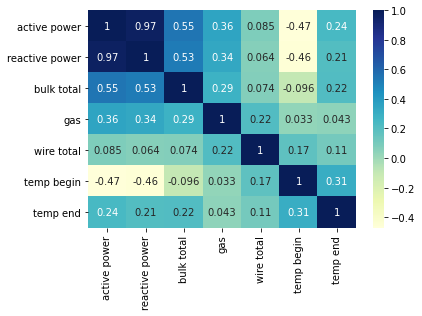

In [39]:
display(data_total.corr(method='spearman'))

dataplot = sns.heatmap(data_total.corr(method='spearman'), cmap="YlGnBu", annot=True)

plt.show()

Тут необходимо принять решение об удалении reactive power из датасета, так как коэффициент корреляции по спирмену очень высок!

In [40]:
data_total = data_total.drop('reactive power', 1)

## 3. Моделирование

In [41]:
df = data_total

In [42]:
df.head()

,active power,bulk total,gas,wire total,temp begin,temp end
0,4.878147,553.0,29.749986,60.059998,1571.0,1613.0
1,3.052598,582.0,12.555561,96.052315,1581.0,1602.0
2,2.525882,544.0,28.554793,91.160157,1596.0,1599.0
3,3.209250,595.0,18.841219,89.063515,1601.0,1625.0
4,3.347173,584.0,5.413692,98.352796,1576.0,1602.0


Разбиваем датасет на признаки и таргеты

In [43]:
target = df['temp end']
features = df.drop(['temp end'], axis = 1)

Разделение на тестовую и обучающую выборку

In [44]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25, random_state = 12345)

In [45]:
print('Размеры тренировочной выборки:')
print(features_train.shape)
print(target_train.shape)

print('Размеры валидационной выборки:')
print(features_test.shape)
print(target_test.shape)

Размеры тренировочной выборки:
(1746, 5)
(1746,)
Размеры валидационной выборки:
(583, 5)
(583,)


In [46]:
print('Скаляризация - уравновешивание признаков...')

scaler = StandardScaler()

features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

Скаляризация - уравновешивание признаков...


***Простая модель линейной регрессии***

In [47]:
model1 = LinearRegression()
model1.fit(features_train, target_train)

LinearRegression()

In [48]:
predictions1_train = model1.predict(features_train)

In [49]:
print('MAE модели на обучающей выборке:', mean_absolute_error(target_train, predictions1_train))

MAE модели на обучающей выборке: 6.82604329481774


In [50]:
predictions1_test = model1.predict(features_test)

In [51]:
print('MAE модели на тестовой выборке:', mean_absolute_error(target_test, predictions1_test))

MAE модели на тестовой выборке: 7.173675006466905


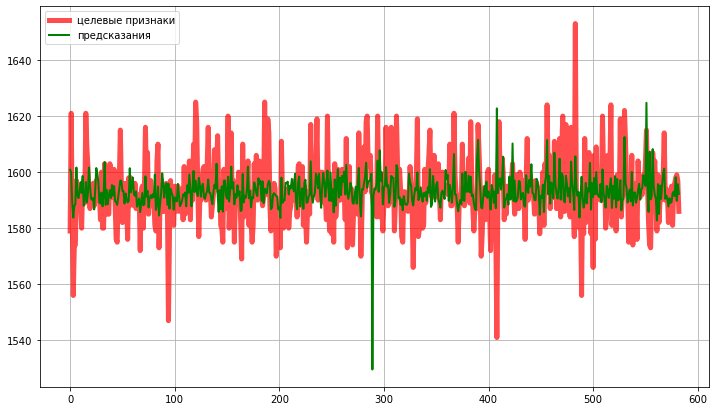

In [52]:
plt.figure(figsize=(12, 7))
plt.plot(list(target_test), '-r', alpha=0.7, label="целевые признаки", lw=5)
plt.plot(list(predictions1_test), '-g', label="предсказания", lw=2)
plt.legend()
plt.grid(True)

***Попробуем обучить и подобрать гиперпараметры для модели градиентного бустинга***

In [53]:
scoring = make_scorer(mean_absolute_error)

In [54]:
parametrs = {'learning_rate': list(np.arange(0.01, 0.05, 0.01)),
                'n_estimators': range(300, 500, 10)}

In [55]:
model = LGBMRegressor(random_state=12345)
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)

In [56]:
print('MAE модели на обучающей выборке:', mean_absolute_error(target_train, predictions_train))

MAE модели на обучающей выборке: 3.6882930710753437


In [57]:
grid = GridSearchCV(model, parametrs, cv=5, scoring = scoring, verbose = 0)
grid.fit(features_test, target_test)
grid.best_params_

{'learning_rate': 0.04, 'n_estimators': 490}

In [58]:
model = LGBMRegressor(random_state=12345, learning_rate = 0.01, n_estimators = 390)
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)

In [59]:
print('MAE модели на обучающей выборке:', mean_absolute_error(target_train, predictions_train))

MAE модели на обучающей выборке: 4.740358324357789


## 4. Проверка модели на тестовой выборке

In [60]:
predictions_test = model.predict(features_test)

In [61]:
print('MAE модели на тестовой выборке:', mean_absolute_error(target_test, predictions_test))

MAE модели на тестовой выборке: 6.706849448688197


**Вывод по части "Код решения"**

Полученный результат MAE на тестовой выборке равен: 6.707

Для регрессии значения конечной температуры была выбрана модель градиентного бустинга LGBMRegressor с соответствующими параметрами, примерно подобранными при помощи GridSearchCV.

GridSearchCV ориентируется на наименьшую MAE на обучающей выборке, но чтобы получить таковую на тестовой были подобраны следующие параметры {'learning_rate': 0.01, 'n_estimators': 390}.

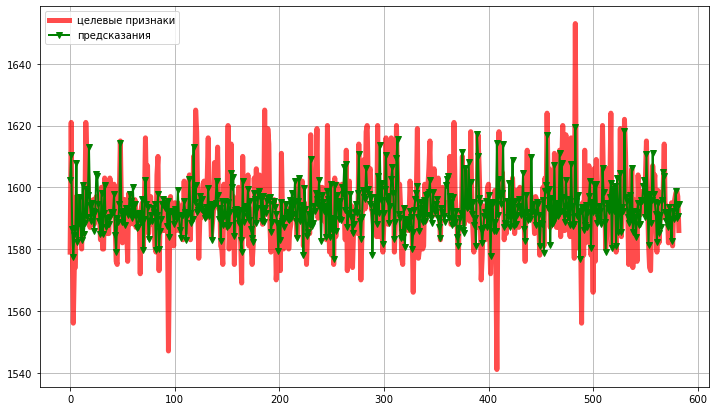

In [62]:
plt.figure(figsize=(12, 7))
plt.plot(list(target_test), '-r', alpha=0.7, label="целевые признаки", lw=5)
plt.plot(list(predictions_test), 'v-g', label="предсказания", lw=2)
plt.legend()
plt.grid(True)

In [63]:
features

,active power,bulk total,gas,wire total,temp begin
0,4.878147,553.0,29.749986,60.059998,1571.0
1,3.052598,582.0,12.555561,96.052315,1581.0
2,2.525882,544.0,28.554793,91.160157,1596.0
3,3.209250,595.0,18.841219,89.063515,1601.0
4,3.347173,584.0,5.413692,98.352796,1576.0
...,...,...,...,...,...
2494,3.210690,719.0,7.125735,89.150879,1570.0
2495,4.203064,796.0,9.412616,114.179527,1554.0
2496,2.212379,665.0,6.271699,103.134723,1571.0
2497,3.408725,733.0,14.953657,118.110717,1591.0


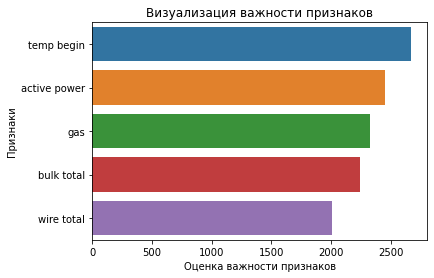

In [64]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(model)

## Итоговый отчет по решению.

**План работы:**  
- Провести исследовательский анализ данных:
    - Посмотреть на распределение исходных данных
    - Проанализировать порядок событий в производственном процессе
    - Исключить партии, которые не имеют последнего замера температуры, либо первый замер соответствует последнему, либо замеры отсутствуют 
    - Оставить только события, которые находятся в промежутке между первым и последним замерами
- Подобрать признаки, на которых будет обучаться модель:
    - Сгенерировать ряд признаков
    - Проверить признаки на мультиколлинеарность, исключить лишние
    - Провести масштабирование признаков
- Построить модель, которая предскажет температуру стали:
    - Сформировать обучающую, валидационную и тестовую выборки
    - Выбрать несколько моделей и проверить их эффективность на валидационной выборке с помощью показателя эффективности MAE
    - Эффективность лучшей модели проверить на тестовой выборке

### Отчет

***1) Соответствие плану:***

    - Был проведен исследовательский анализ данных входящих датасетов, предобработка и исключение ненужных признаков и событий;
    
    - По результатам предыдущего этапа был сгенерирован ряд признаков для дальнейшего обучения на них модели; признаки были проверены на мультиколлениарность (лишние, при условии высокой корреляции с другими признаками и важности факторов, были удалены) и масштабированы;
    
    - Была построена модель, предсказывающая температуру, MAE которой на тестовой выборке получилась 6.707 (то есть, в среднем, модель дает результат с точностью +-6.7 градусов).
    
    Итого: все пункты, заявленные ранее в плане проекта были выполнены с достижением соответствующего оптимального результата MAE обученной модели.
    
***2) Трудности, возникшие в проекте:***

    - Данные были разбиты на разные таблицы: при формировании итоговой таблицы признаков и таргетов для обучения модели были необходимы предобработка и формирование отдельного датасета путем отбрасывания и добавления новых столбцов, а также проверки на мультиколлинеарность и важность признаков;
    
    - Подбор гиперпараметров модели градиентного бустинга.
    
    Итого: итоговая таблица была успешно сформирована с учетом всех факторов; решение трудности подбора гиперпараметров модели градиентного бустинга - использование моделей подбора гиперпараметров, таких как GridSearchCV.
    
***3) Ключевые шаги в решении задачи модели:***

    - Несомненно, наиболее важным фактором в решении кейса есть наличие и правильность составления плана работы! Это основа основ, определяющая наш итоговый результат, при следовании которой мы сможем достичь необходимого результата, а при отклонении - извлечь для себя новые инсайты, направления развития и пути совершенстсования разрабатываемой модели прогнозирования;

    - Правильное формирование итогового датасета для обучения моделей на нем: важно правильно подобрать признаки, а также проверить необходимость их наличия при помощи проверки на мультиколлинеарность, ведь слишком большое число признаков может "загрузить" модель, а пропуски и выбросы в признаках привести к ошибкам в предсказаниях модели;
    
    - Уделение должного внимания подбору гиперпараметров: от использования моделей подбора параметров до применения навыков собственной интуиции :).
    
    Итого: была получена модель с соответствующими характеристиками, описанными пунктом ниже.
    
***4) Итоговая модель*** - модель градиентного бустинга LGBMRegressor(). MAE итоговой модели на тестовой выборке - 6.707 (то есть, в среднем, модель дает результат с точностью +-6.7 градусов).